In [2]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import os
import pandas as pd
from PIL import Image
from torch.utils.data import Dataset

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms

In [13]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(32 * 24 * 24, 1024)
        self.fc2 = nn.Linear(1024, 256)
        self.fc3 = nn.Linear(256, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(-1, 32 * 24 * 24)
        
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        x = self.sigmoid(x) 
        return x

To select my model architecture, I started with a simple model and separated the train/validation data. Then only looking at the train data, I added complexity to the model (additional layers and increased hidden units) until the increased reduction in the loss provided by the greater model complexity slowed.

In [5]:
class CustomDataset(Dataset):
    def __init__(self, root_dir, labels_df, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        
        # Load labels from CSV file
        self.labels_df = labels_df
        
    def __len__(self):
        return len(self.labels_df)
    
    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.labels_df.iloc[idx, 0]) + '.tif'
        image = Image.open(img_name)
        
        # Extract label from CSV
        label = self.labels_df.iloc[idx, 1]
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

transform = transforms.Compose([
    transforms.ToTensor()
])

data_dir = 'C:\\Users\\natha\Documents\\PythonNotebooks\\data\\Cancer\\'
df = pd.read_csv(os.path.join(data_dir, 'train_labels.csv'))
train = df.sample(frac=0.85, random_state=42)
test = df.drop(train.index)

batch_size = 64

image_dir = os.path.join(data_dir, 'train')
train_data = CustomDataset(image_dir, train, transform=transform)
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True, pin_memory=True)

test_data = CustomDataset(image_dir, test, transform=transform)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=False, pin_memory=True)

In [9]:
labels.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


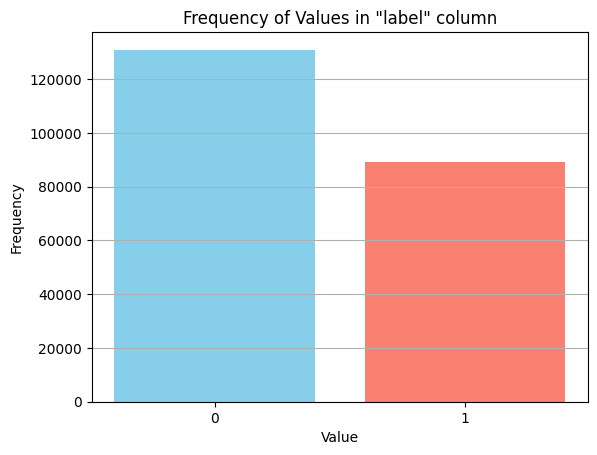

In [12]:
value_counts = labels['label'].value_counts()
plt.bar(value_counts.index, value_counts.values, color=['skyblue', 'salmon'])
plt.title('Frequency of Values in "label" column')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.xticks(value_counts.index)  # Setting x-axis ticks to the unique values in 'target'
plt.grid(axis='y')  # Add grid lines for better readability
plt.show()

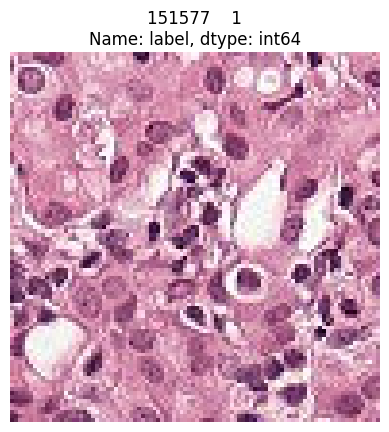

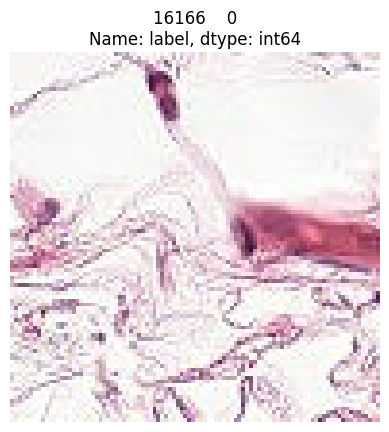

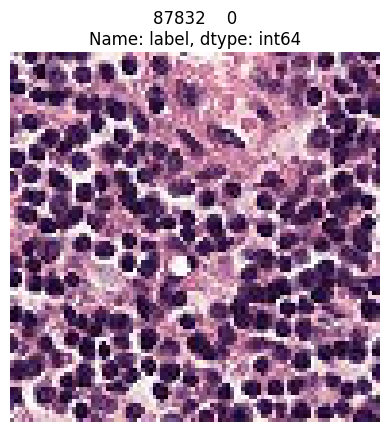

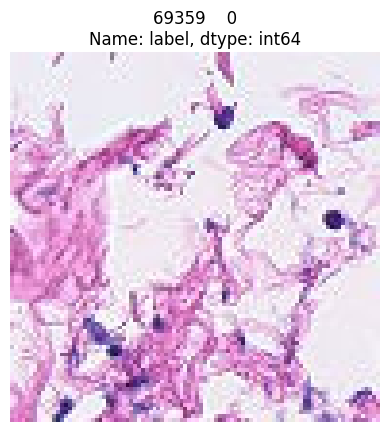

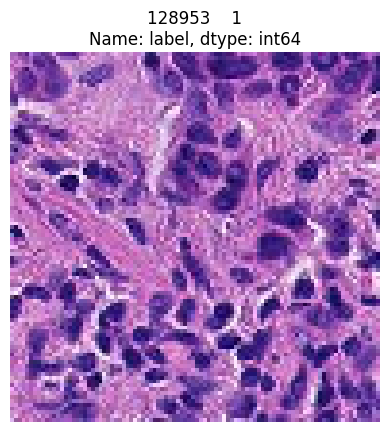

In [15]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
label_file = 'C:\\Users\\natha\Documents\\PythonNotebooks\\data\\Cancer\\train_labels.csv'
data_dir = 'C:\\Users\\natha\Documents\\PythonNotebooks\\data\\Cancer\\train\\'
labels = pd.read_csv(label_file)
file_list = os.listdir(data_dir)
for i in range(min(5, len(file_list))):
    file_path = os.path.join(data_dir, file_list[i])
    img = mpimg.imread(file_path)
    plt.imshow(img)
    plt.axis('off')  # Hide axes
    label = labels.loc[labels['id'] == file_list[i].split('.')[0]]['label']
    plt.title(label)  # Show filename as title
    plt.show()

The class labels aren't quite even but are close enough. Displayed a few of the images with their labels to get an idea of what we're looking at in the data.

In [15]:
model = SimpleCNN()

# Define the loss function and optimizer
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss for binary classification
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Set device to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

num_epochs = 3
for epoch in range(num_epochs):
    running_train_loss = 0.0
    running_test_loss = 0.0
    correct_train = 0
    total_train = 0
    false_negative_train = 0
    total_positive_train = 0
    correct_test = 0
    total_test = 0
    false_negative_test = 0
    total_positive_test = 0
    
    for i, data in enumerate(train_dataloader):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device).float()  # Convert labels to float
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels.unsqueeze(1))  # Unsqueeze labels to match output shape
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_train_loss += loss.item() * inputs.size(0)

        predicted = (outputs > 0.5).float()
        correct_train += (predicted == labels.unsqueeze(1)).sum().item()
        total_train += labels.size(0)
        
        # Compute false negative rate
        false_negative_train += ((predicted == 0) & (labels.unsqueeze(1) == 1)).sum().item()
        total_positive_train += (labels == 1).sum().item()
        
    model.eval()
    with torch.no_grad(): 
        for i, data in enumerate(test_dataloader):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device).float()
            
            outputs = model(inputs)
            loss = criterion(outputs, labels.unsqueeze(1))
            
            running_test_loss += loss.item() * inputs.size(0)

            predicted = (outputs > 0.5).float()
            correct_test += (predicted == labels.unsqueeze(1)).sum().item()
            total_test += labels.size(0)
            
            # Compute false negative rate
            false_negative_test += ((predicted == 0) & (labels.unsqueeze(1) == 1)).sum().item()
            total_positive_test += (labels == 1).sum().item()

    epoch_train_loss = running_train_loss / len(train_dataloader.dataset)
    epoch_test_loss = running_test_loss / len(test_dataloader.dataset)
    
    # Calculate accuracy
    train_accuracy = correct_train / total_train
    test_accuracy = correct_test / total_test
    
    # Calculate false negative rate
    false_negative_rate_train = false_negative_train / total_positive_train
    false_negative_rate_test = false_negative_test / total_positive_test
    
    # Print statistics
    print(f'Epoch [{epoch+1}/{num_epochs}]')
    print(f'Train Loss: {epoch_train_loss:.4f}')
    print(f'Train Accuracy: {train_accuracy:.4f}')
    print(f'Train False Negative Rate: {false_negative_rate_train:.4f}')
    print(f'Test Loss: {epoch_test_loss:.4f}')
    print(f'Test Accuracy: {test_accuracy:.4f}')
    print(f'Test False Negative Rate: {false_negative_rate_test:.4f}')

torch.save(model.state_dict(), 'files/cancer_model.pth')

Epoch [1/3]
Train Loss: 0.4139
Train Accuracy: 0.8168
Train False Negative Rate: 0.2677
Test Loss: 0.3483
Test Accuracy: 0.8491
Test False Negative Rate: 0.2692
Epoch [2/3]
Train Loss: 0.3241
Train Accuracy: 0.8616
Train False Negative Rate: 0.1884
Test Loss: 0.3134
Test Accuracy: 0.8685
Test False Negative Rate: 0.1642
Epoch [3/3]
Train Loss: 0.2759
Train Accuracy: 0.8849
Train False Negative Rate: 0.1536
Test Loss: 0.3190
Test Accuracy: 0.8627
Test False Negative Rate: 0.2559


To settle on hyperparameters for training, I printed out the loss on a longer training run and watched for the test loss to stop decreasing. This happened around 3 epochs so I trained the model with only 3 epochs for the final predictions.

In [23]:
import torch
from torchvision import transforms
from PIL import Image
import os

testing_folder = 'C:\\Users\\natha\Documents\\PythonNotebooks\\data\\Cancer\\test\\'

# Define transformations to be applied to your images
image_transform = transforms.Compose([
    transforms.ToTensor()
])

# Define function to load and preprocess images
def preprocess_image(image_path):
    image = Image.open(image_path)
    image = image_transform(image)
    return image.unsqueeze(0) 

# Load your trained model
model = SimpleCNN()
model.load_state_dict(torch.load("files/cancer_model.pth"))
model.eval()

# Function to predict the class of an image
def predict_image_class(image_path, model):
    image = preprocess_image(image_path)
    with torch.no_grad():
        output = model(image)
        predicted_class = torch.round(output).item()
    return predicted_class

rows = []
# Iterate through images in the folder and classify them
for image_file in os.listdir(testing_folder):
    image_path = os.path.join(testing_folder, image_file)
    predicted_class = predict_image_class(image_path, model)
    rows.append({'id': image_file.split('.')[0], 'label': int(predicted_class)})

In [24]:
len(rows)

57458

In [26]:
pd.DataFrame(data=rows).to_csv('files/submission.csv', index=False)